In [1]:
from mynotebooks import *
%matplotlib inline

# Arm Creation : Joint Limits have an impact on learning: default arm is non lateralized high range limits
arm = Box2DWorld.Arm(position=(0,0), nparts=3, bHand=False, bShrink = True, bLateralize = 1)  

Created Left Lateralized Arm Lims:  [-1.26, -2.73, -2.73] [1.26, 0.0, 0.63]


/usr/local/lib/python2.7/site-packages/matplotlib/patches.py:121: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


#### Arm Min Joints Values <font color='red'> CANNOT </font> be reached beacuse of self collisions 

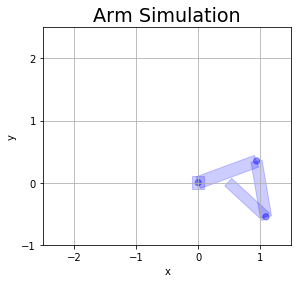

In [2]:
fig, ax = Box2DWorld.makeFigure(axes=[-2.5,1.5,-1,2.5])

m = arm.m_mins()           # arm minimum joint angles cannot be reached because of self collision
arm.gotoTargetJoints(m)    
motor = arm.getJointPositionsXY()
Box2DWorld.plotAll(ax,alpha=0.2,centers=motor,cradius=0.05,ccolor='b',xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)
plt.show()

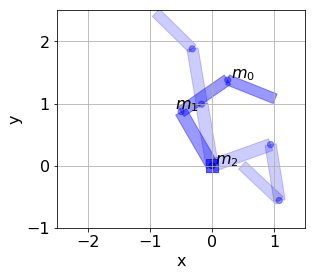

In [3]:
fig, ax = Box2DWorld.makeFigure(axes=[-2.5,1.5,-1,2.5])

mlist = [arm.m_mins(), arm.m_maxs()]
for m in mlist:
    arm.gotoTargetJoints(m)    
    motor = arm.getJointPositionsXY()
    Box2DWorld.plotAll(ax,alpha=0.2,centers=motor,cradius=0.05,ccolor='b',xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)

m = [0.5,-1.5,-1] # absolute motor joint angles in rad:  limits -2..2, 90 degrees
arm.gotoTargetJoints(m)    
joints = arm.getJointPositionsXY()
Box2DWorld.plotAll(ax,alpha=0.4,centers=joints,cradius=0.05,ccolor='b',label="m",xlabel="x",ylabel="y",mainfont=16) # title="Lateralized Arm"
    
plt.show()
fig.savefig('imgs/0-setups.png', dpi=300, format='png')

## Sensorimotor mapping : f(m)=s

In [2]:
env = SensoriMotor.RobotArmEnv(arm.m_mins(), arm.m_maxs(), arm.s_mins(), arm.s_maxs())
fms = SensorimotorModel.from_configuration(env.conf, 'nearest_neighbor')

In [3]:
def forward_errors(motor_probes):
    fms.mode = "exploit"
    errors = []
    for m in motor_probes:
        s = np.array(arm.gotoTargetJoints(m))
        s_pred = fms.forward_prediction(m)
        errors.append(VectorFigUtils.dist(s,s_pred))
    fms.mode = "explore"
    return errors

def inv_fwd_errors(motor_probes):
    fms.mode = "exploit"
    errors = []
    for m in motor_probes:
        s = np.array(arm.gotoTargetJoints(m))
        errors.append(ExplautoUtils.errorInvFwd(fms,s))
    fms.mode = "explore"
    return errors

### f(m)=s learning random motor babbling

. 0 . . . . . 50 ( 0.458956531847 ) . . . . . 100 ( 0.462035621398 ) . . . . . 150 ( 0.254182699872 ) . . . . . 200 ( 0.309007062532 ) . . . . . 250 ( 0.321429939942 ) . . . . . 300 ( 0.405951606359 ) . . . . . 350 ( 0.244569984088 ) . . . . 
Learn f(m,s) tuples: 355 error 0.290131888859


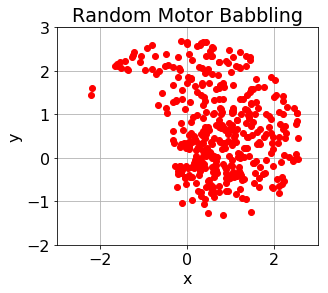

In [6]:
fig, ax = Box2DWorld.makeFigure(axes=[-3,3,-2,3])

errors = [0]
mean_error_fwd,mean_var_fwd = [],[]
mean_error_invfwd,mean_var_invfwd = [],[]

for i in range(400):
    Box2DWorld.printProgress(i, np.mean(errors))    
    m = env.getRandomInput()
    s = env.compute_sensori_effect(m)     
    #Box2DWorld.plotWorld(ax)
    ax.plot(*s, marker='o', color='red')
    
    err = 1
    if(fms.size()>1):
        s_pred = fms.forward_prediction(m)
        err = VectorFigUtils.dist(s,s_pred)
        motor_probes = env.random_motors(n=20)
        VectorFigUtils.error_monitor(forward_errors(motor_probes), mean_error_fwd, mean_var_fwd)        
        VectorFigUtils.error_monitor(inv_fwd_errors(motor_probes), mean_error_invfwd, mean_var_invfwd)               
    
    if(err > 0.1): fms.update(m, s) 
        
    errors.append(err)
    if(len(errors) > 20): errors.pop(0)    
        
    
print "\nLearn f(m,s) tuples:", fms.size(), "error", np.mean(errors)
VectorFigUtils.decorate("x","y","Random Motor Babbling",mainfont=16)
plt.grid()
plt.show()
fig.savefig('imgs/RandomBabbling.png', dpi=300, format='png')

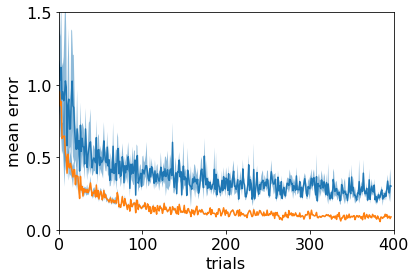

In [7]:
plt.close()
plt.axes(xlim=[0,400],ylim=[0,1.5])
VectorFigUtils.drawPlotXY(range(len(mean_error_fwd)),mean_error_fwd,mean_var_fwd,xlabel="trials",ylabel="mean error")
VectorFigUtils.drawPlotXY(range(len(mean_error_invfwd)),mean_error_invfwd,mean_var_invfwd,xlabel="trials",ylabel="mean error")
plt.show()
#fig.savefig('imgs/RandomBablingError.png', dpi=300, format='png')

Error:  0.28319604517


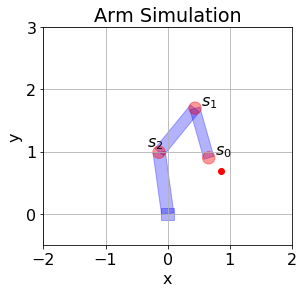

In [18]:
# individual test of a forward prediction
fms.mode = "exploit" 
fig, ax = Box2DWorld.makeFigure(axes=[-2,2,-0.5,3])
m = env.random_motors(n=1)[0]
s = np.array(arm.gotoTargetJoints(m))
s_pred = fms.forward_prediction(m)
print "Error: ", VectorFigUtils.dist(s,s_pred)
Box2DWorld.plotAll(ax,centers=arm.getSalient(),label="s",xlabel="x",ylabel="y",title="Arm Simulation",mainfont=16)
ax.plot(*s_pred, marker='o', color='red')
plt.show()

### Goal Babbling with progres monitoring sampling an Interest Model

. 0 . . . . . 50 ( 1.99912591598 ) . . . . . 100 ( 1.07551994187 ) . . . . . 150 ( 1.1916824202 ) . . . . . 200 ( 0.675682893816 ) . . . . . 250 ( 0.691215147603 ) . . . . . 300 ( 2.02821043938 ) . . . . . 350 ( 0.488520231966 ) . . . . 
Learn f(m,s) tuples: 400 error 0.925433469261


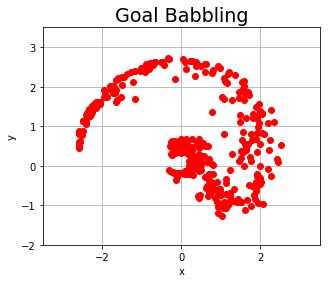

In [4]:
fms_im = InterestModel.from_configuration(env.conf, env.conf.s_dims, 'discretized_progress')

fig, ax = Box2DWorld.makeFigure(axes=[-3.5,3.5,-2,3.5])
errors,mean_bab_error,mean_bab_var = [0],[],[]
for i in range(400):
    Box2DWorld.printProgress(i,np.mean(errors))    
    s_g = fms_im.sample()                                   # sample a sensory goal using the interest model
    if(fms.size()>1): m = fms.inverse_prediction(s_g)       # infer a motor command to reach that goal using the sensorimotor model
    else: m = env.getRandomInput()
        
    s = env.compute_sensori_effect(m)                       # execute this command and observe the corresponding sensory effect
    #Box2DWorld.plotWorld(ax)                # plot world always after sensori effect
    ax.plot(*s, marker='o', color='red')

    fms.update(m, s)                        # update the sensorimotor model
    
    err = VectorFigUtils.dist(s,s_g)
    errors.append(err)
    if(len(errors) > 20): errors.pop(0)    
        
    if(fms.size()>1): 
        motor_probes = env.random_motors(n=20)
        VectorFigUtils.error_monitor(inv_fwd_errors(motor_probes), mean_bab_error,mean_bab_var)            
        fms_im.update(np.hstack((m, s_g)), np.hstack((m, s)))                    # update the interest model
    
print "\nLearn f(m,s) tuples:", fms.size(), "error", np.mean(errors)
VectorFigUtils.decorate("x","y","Goal Babbling",mainfont=16)
plt.grid()
plt.show()
fig.savefig('imgs/RandomGoalBabbling.png', dpi=300, format='png')

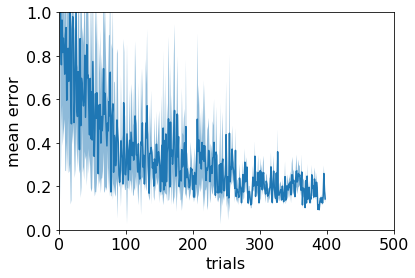

In [5]:
plt.close()
plt.axes(xlim=[0,500],ylim=[0,1])
VectorFigUtils.drawPlotXY(range(len(mean_bab_error)),mean_bab_error,mean_bab_var,xlabel="trials",ylabel="mean error")
plt.show()
#fig.savefig('imgs/RandomBablingError.png', dpi=300, format='png')